Questa versione fa DQN con epsilon greedy decay

NN: Flatted input > Dense(64) > Dense(64) > Dense(4)

# Snake

In [ ]:
import environments_fully_observable
import environments_partially_observable
import numpy as np
from  tqdm import trange
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)

## Environment definition

In [ ]:
size = 7
%matplotlib inline
# function to standardize getting an env for the whole notebook
def get_env(n=1000):
    # n is the number of boards that you want to simulate parallely
    # size is the size of each board, also considering the borders
    # mask for the partially observable, is the size of the local neighborhood
    e = environments_fully_observable.OriginalSnakeEnvironment(n, size)
    # or environments_partially_observable.OriginalSnakeEnvironment(n, size, 2)
    return e
env_ = get_env()
GAMMA = .9
ITERATIONS = 5000

fig,axs=plt.subplots(1,min(len(env_.boards), 3), figsize=(10,3))
for ax, board in zip(axs, env_.boards):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(board)

 ### Random policy reward

Just a baseline (not the one you are supposed to develop)

In [ ]:
random_env = get_env(100)
random_rewards = []
fruit_data = []
head_data = []
body_data = []

for i in range(100):
    probs = tf.convert_to_tensor([[.25]*4]*random_env.n_boards)
    #sample actions
    actions =  tf.random.categorical(tf.math.log(probs), 1, dtype=tf.int32)

    # Save the data of the first board
    heads = np.argwhere(random_env.boards == random_env.HEAD) # find the head in the board for all the games
    fruits = np.argwhere(random_env.boards == random_env.FRUIT) # find the fruit in the board for all the games
    bodies = np.argwhere(random_env.boards == random_env.BODY)
    filtered_body = [[row[1], row[2]] for row in bodies if row[0] == 0]

    fruit_data.append([fruits[0][1],fruits[0][2]])
    head_data.append([heads[0][1],heads[0][2]])
    body_data.append(filtered_body)

    # MDP update
    rewards = random_env.move(actions)
    random_rewards.append(np.mean(rewards))

# Plot the reward
plt.plot(range(len(random_rewards)),random_rewards)
plt.xlabel('Iter')
plt.ylabel('Mean Rewards')
plt.title('Plot of Rewards')
plt.grid(True)
plt.show()

# **DDQN**

In [ ]:
class DDQN(tf.keras.Model):
    def __init__(self, action_dim):
        super(DDQN, self).__init__()
        self.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(action_dim)
        ])

In [ ]:
# Example of usage
env = get_env(1)
action_dim = 4  # Dimensionality of the action space

# Create an instance of the QN model
q_net = DDQN(action_dim)
# Compile the model
q_net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                 loss=[tf.keras.losses.MeanSquaredError()],
                 metrics=[['accuracy']])

# Example usage: obtain Q-values for a state
state = env.to_state().flatten()
state = tf.expand_dims(state, axis=0)  # Add batch dimension
q_values = q_net.model(state)

print("Q-values:", q_values)
best_action = q_values.numpy().argmax().item()
print("Best action index:", best_action)

# Collect one step in the environments

In [ ]:
def collect_one_step(envs, q_net, epsilon):
    """
    Collects one transitions S,A,R,S'

    Args:
    - envs: The environments.
    - a2c: The NN.

    Returns:
    - states, actions, rewards, next_states
    """

    states = envs.to_state()

    q_values = q_net.model(states)

    if np.random.rand() < epsilon:
      actions = tf.random.categorical(q_values, 1)
    else:
      actions = tf.expand_dims(tf.argmax(q_values, axis=1), axis=1)

    # Observe rewards
    rewards = envs.move(actions)

    next_states = envs.to_state()

    return states, actions, rewards, next_states

In [ ]:
# Example of usage
# Initialize the environment
envs = get_env(256)
action_dim = 4  # Dimensionality of the action space

# Create an instance of the QN model
q_net = DDQN(action_dim)

# Hyperparams
epsilon = 0.5

states, actions, rewards, next_states = collect_one_step(envs, q_net, epsilon)

print(states.shape, actions.shape, rewards.shape, next_states.shape)

# Get Lengths of snake

In [ ]:
def get_length(bodies, total_envs):
  # Get unique board numbers and their counts
  board_numbers, counts = np.unique(bodies[:, 0], return_counts=True)

  # Create a tensor with all board numbers and initial count of 1
  lengths = np.ones((total_envs, 1), dtype=int)

  # Update the tensor with counts from the data
  for board_number, count in zip(board_numbers, counts):
      lengths[int(board_number) - 1] = count +1

  lengths_tensor = tf.convert_to_tensor(lengths)
  lengths_tensor = tf.cast(lengths_tensor, tf.float32)

  return lengths_tensor

In [ ]:
def distances(envs):
    heads = np.argwhere(envs.boards == envs.HEAD)
    fruits = np.argwhere(envs.boards == envs.FRUIT)

    distances = heads - fruits
    
    # Slice the array to exclude the first column
    coordinates = distances[:, 1:]
    # Compute the Euclidean distance for each pair of coordinates
    euclidean_distances = np.sqrt(np.sum(coordinates**2, axis=1))

    # Convert NumPy array to TensorFlow tensor
    distances_tensor = tf.convert_to_tensor(euclidean_distances.reshape(-1, 1))
    distances_tensor = tf.cast(distances_tensor, tf.float32)
    
    return distances_tensor

In [ ]:
def mod_rewards(envs, rewards, train_step):

    # Compute new values for rewards - function 3
    # Adjust rewards and penalties based on train_step
    if train_step > 0:

        lengths = get_length(np.argwhere(envs.boards == envs.BODY), envs.n_boards)
        
        condition = tf.logical_and(tf.greater(lengths, 5), tf.equal(rewards, -0.2))
        rewards = tf.where(tf.equal(rewards, -0.2), -0.5, rewards)

        #condition = tf.logical_and(tf.greater(lengths, 10), tf.equal(rewards, -0.2))
        #rewards = tf.where(tf.equal(rewards, -0.2), -1, rewards)

        #condition = tf.logical_and(tf.greater(lengths, 15), tf.equal(rewards, -0.2))
        #rewards = tf.where(tf.equal(rewards, -0.2), -1.5, rewards)

        #condition = tf.logical_and(tf.greater(lengths, 20), tf.equal(rewards, -0.2))
        #rewards = tf.where(tf.equal(rewards, -0.2), -2, rewards)

        condition = tf.logical_and(tf.greater(lengths, 5), tf.equal(rewards, 0.5))
        rewards = tf.where(condition, 0.6, rewards)

        condition = tf.logical_and(tf.greater(lengths, 10), tf.equal(rewards, 0.5))
        # Apply the modification
        rewards = tf.where(condition, 0.8, rewards)

        condition = tf.logical_and(tf.greater(lengths, 15), tf.equal(rewards, 0.5))
        # Apply the modification
        rewards = tf.where(condition, 1.1, rewards)

        condition = tf.logical_and(tf.greater(lengths, 20), tf.equal(rewards, 0.5))
        # Apply the modification
        rewards = tf.where(condition, 1.5, rewards)

        win = 2.
        rewards = tf.where(tf.equal(rewards, 1.), win, rewards)
    
    return rewards

# Plot

In [ ]:
def plotting(max_steps, n_fruit_eaten, n_wall_hit, n_body_hit, rewards):
  # Create a figure and axis objects
  fig, axs = plt.subplots(1, 4, figsize=(15, 5))

  # Plot n_fruit_eaten
  axs[0].plot(range(1, max_steps + 1), n_fruit_eaten)
  axs[0].set_xlabel('Training Steps')
  axs[0].set_ylabel('Eaten fruits')
  axs[0].set_title('Eaten fruits over Training Steps')

  # Plot n_wall_hit
  axs[1].plot(range(1, max_steps + 1), n_wall_hit)
  axs[1].set_xlabel('Training Steps')
  axs[1].set_ylabel('Wall hit')
  axs[1].set_title('Wall hit over Training Steps')

  # Plot n_body_hit
  axs[2].plot(range(1, max_steps + 1), n_body_hit)
  axs[2].set_xlabel('Training Steps')
  axs[2].set_ylabel('Body hit')
  axs[2].set_title('Body hit over Training Steps')

  # Plot n_fruit_eaten
  axs[3].plot(range(1, max_steps + 1), rewards)
  axs[3].set_xlabel('Training Steps')
  axs[3].set_ylabel('Rewards')
  axs[3].set_title('Rewards over Training Steps')

  for ax in axs:
        ax.grid(True)
        
  # Adjust layout
  plt.tight_layout()

  # Show the plot
  plt.show()

## Linear Schedule

In [ ]:
def linear_schedule(initial_value: float, final_value: float, current_step: int, max_steps: int) -> float:
    """
    Linear schedule for the exploration rate (epsilon).
    Note: we clip the value so the schedule is constant after reaching the final value
    at `max_steps`.

    :param initial_value: Initial value of the schedule.
    :param final_value: Final value of the schedule.
    :param current_step: Current step of the schedule.
    :param max_steps: Maximum number of steps of the schedule.
    :return: The current value of the schedule.
    """
    # Compute current progress (in [0, 1], 0 being the start)
    progress = current_step / max_steps
    # Clip the progress so the schedule is constant after reaching the final value
    progress = min(progress, 1.0)
    current_value = initial_value + progress * (final_value - initial_value)

    return current_value

# Learn

In [ ]:
def learn(q_net, target_q_net, optimizer, gamma, states, next_states, actions, rewards, batch_size):

  with tf.GradientTape(persistent=True) as tape:
    # Compute the Q-values for the next observations
    next_q_values = target_q_net.model(next_states)

    # Follow greedy policy: use the one with the highest value
    next_q_values = tf.reduce_max(next_q_values, axis=1)

    # TD error
    td_target = rewards + gamma * next_q_values[:, tf.newaxis] # * tf.cast(~dones, tf.float32)

    # Get current Q-values estimates for the replay_data
    q_values = q_net.model(states)

    # Use tf.gather to gather the action values corresponding to chosen action indices
    current_q_values = tf.gather(q_values, actions, batch_dims=1)

    # Compute the Mean Squared Error (MSE) loss
    loss = tf.reduce_mean(tf.square(current_q_values - td_target))

  # Compute gradients
  gradients = tape.gradient(loss, q_net.model.trainable_weights)
  # Apply gradients
  optimizer.apply_gradients(zip(gradients, q_net.model.trainable_weights))

  return loss

def update_target(q_net, target_q_net):
    """
    Update the weights of the target Q-network to match the main Q-network.

    :param q_net: The main Q-network
    :param target_q_net: The target Q-network
    """
    target_q_net.model.set_weights(q_net.model.get_weights())

# Train

In [ ]:
def train(envs, q_net, target_q_net, optimizer, gamma, batch_size, max_steps, epsilon_start, epsilon_end, limit, update_target_frequency):

  rewardsF = []
  n_fruit_eaten = []
  n_wall_hit = []
  n_body_hit = []

  for step in trange(1, max_steps + 1):

      # Update epsilon value
      epsilon = linear_schedule(epsilon_start, epsilon_end, step, max_steps * limit)
         
      # Do one step in the environment
      states, actions, rewards, next_states = collect_one_step(envs, q_net, epsilon)

      n_fruit_eaten.append(np.count_nonzero(np.array(rewards) == .5))
      n_wall_hit.append(np.count_nonzero(np.array(rewards) == -.1))
      n_body_hit.append(np.count_nonzero(np.array(rewards) == -.2))
      rewardsF.append(np.mean(np.array(rewards)))

      if step % 1000 == 0:
         print(f"Mean Reward: {round(np.mean(np.array(rewards)), 4)} - Epsilon: {round(epsilon, 2)}")

      rewards = mod_rewards(envs, rewards, step)

      # Learning
      loss = learn(q_net, target_q_net, optimizer, gamma, states, next_states, actions, rewards, batch_size)

      # Periodically update the target network
      if step % update_target_frequency == 0:
          update_target(q_net, target_q_net)

  print("Training complete!")

  return rewardsF, n_fruit_eaten, n_wall_hit, n_body_hit

# Test

In [ ]:
def test(envs, q_net, max_steps):

  rewardsF = []
  n_fruit_eaten = []
  n_wall_hit = []
  n_body_hit = []
  fruit_data = []
  head_data = []
  body_data = []

  for _ in trange(1, max_steps + 1):

      # Update epsilon value
      epsilon = 0

      # Do one step in the environment
      _, _, rewards, _ = collect_one_step(envs, q_net, epsilon)

      # Save data for plot
      n_fruit_eaten.append(np.count_nonzero(np.array(rewards) == .5))
      n_wall_hit.append(np.count_nonzero(np.array(rewards) == -.1))
      n_body_hit.append(np.count_nonzero(np.array(rewards) == -.2))
      rewardsF.append(np.mean(np.array(rewards)))

      # Save the data of the game rendering
      heads = np.argwhere(envs.boards == envs.HEAD) # find the head in the board for all the games
      fruits = np.argwhere(envs.boards == envs.FRUIT) # find the fruit in the board for all the games
      bodies = np.argwhere(envs.boards == envs.BODY)
      filtered_body = [[row[1], row[2]] for row in bodies if row[0] == 0]

      fruit_data.append([fruits[0][1],fruits[0][2]])
      head_data.append([heads[0][1],heads[0][2]])
      body_data.append(filtered_body)

  print("Testing complete!")

  return rewardsF, n_fruit_eaten, n_wall_hit, n_body_hit, fruit_data, head_data, body_data

# Do it

In [ ]:
batch_size = 256

# Initialize the environment
envs = get_env(batch_size)
action_dim = 4  # Dimensionality of the action space

# Create an instance of the QN model
q_net = DDQN(action_dim)
# Compile the model
q_net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                 loss=[tf.keras.losses.MeanSquaredError()],
                 metrics=[['accuracy']])

target_q_net = DDQN(action_dim)
# Compile the model
target_q_net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                 loss=[tf.keras.losses.MeanSquaredError()],
                 metrics=[['accuracy']])

optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)

# Hyperparams
gamma = 0.99
max_steps = int(20_000)
epsilon_start = 1.0
epsilon_end = 0.01
limit = 0.3
update_target_frequency = 1000

iterations_per_second = 17

# Calculate total time in seconds
total_seconds = max_steps / iterations_per_second

# Convert seconds to days, hours, and minutes
total_days = total_seconds // (24 * 3600)
remaining_seconds = total_seconds % (24 * 3600)
total_hours = remaining_seconds // 3600
remaining_seconds %= 3600
total_minutes = remaining_seconds // 60

# Print the result
print(f"Training time: {int(total_days)} days, {int(total_hours)} hours, {int(total_minutes)} minutes.")

In [17]:
# Run training
rewards_tr, n_fruit_eaten_tr, n_wall_hit_tr, n_body_hit_tr = train(envs, q_net, target_q_net, optimizer, gamma, batch_size, max_steps, epsilon_start, epsilon_end, limit, update_target_frequency)

 60%|██████    | 12001/20000 [12:24<08:50, 15.09it/s]

Mean Reward: 0.11640000343322754 - Epsilon: 0.01


 65%|██████▌   | 13001/20000 [13:25<07:00, 16.63it/s]

Mean Reward: 0.1348000019788742 - Epsilon: 0.01


 70%|███████   | 14001/20000 [14:24<06:18, 15.85it/s]

Mean Reward: 0.14259999990463257 - Epsilon: 0.01


 75%|███████▌  | 15001/20000 [15:24<04:55, 16.93it/s]

Mean Reward: 0.15000000596046448 - Epsilon: 0.01


 80%|████████  | 16001/20000 [16:26<04:14, 15.70it/s]

Mean Reward: 0.12269999831914902 - Epsilon: 0.01


 85%|████████▌ | 17002/20000 [17:31<03:00, 16.65it/s]

Mean Reward: 0.14489999413490295 - Epsilon: 0.01


 90%|█████████ | 18002/20000 [18:33<02:02, 16.28it/s]

Mean Reward: 0.13439999520778656 - Epsilon: 0.01


 95%|█████████▌| 19002/20000 [19:36<01:01, 16.26it/s]

Mean Reward: 0.08160000294446945 - Epsilon: 0.01


100%|██████████| 20000/20000 [20:48<00:00, 16.02it/s]

Mean Reward: 0.1476999968290329 - Epsilon: 0.01
Training complete!


### Save model

In [18]:
q_net.model.save_weights('weights_ddqn_rew.weights.h5')

### Plot

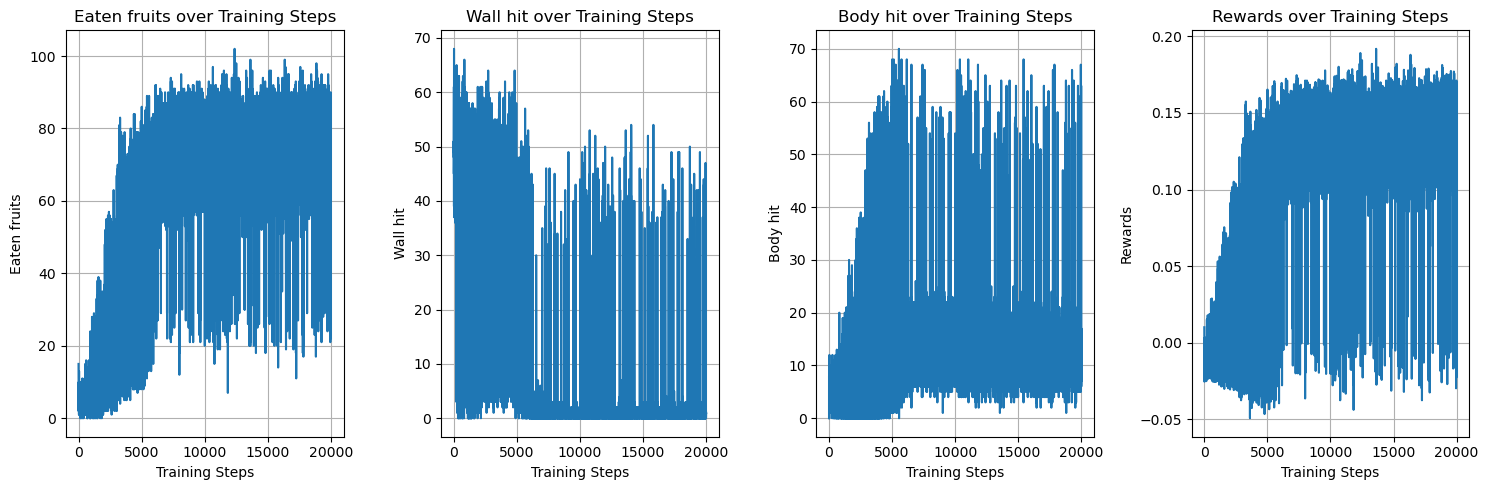

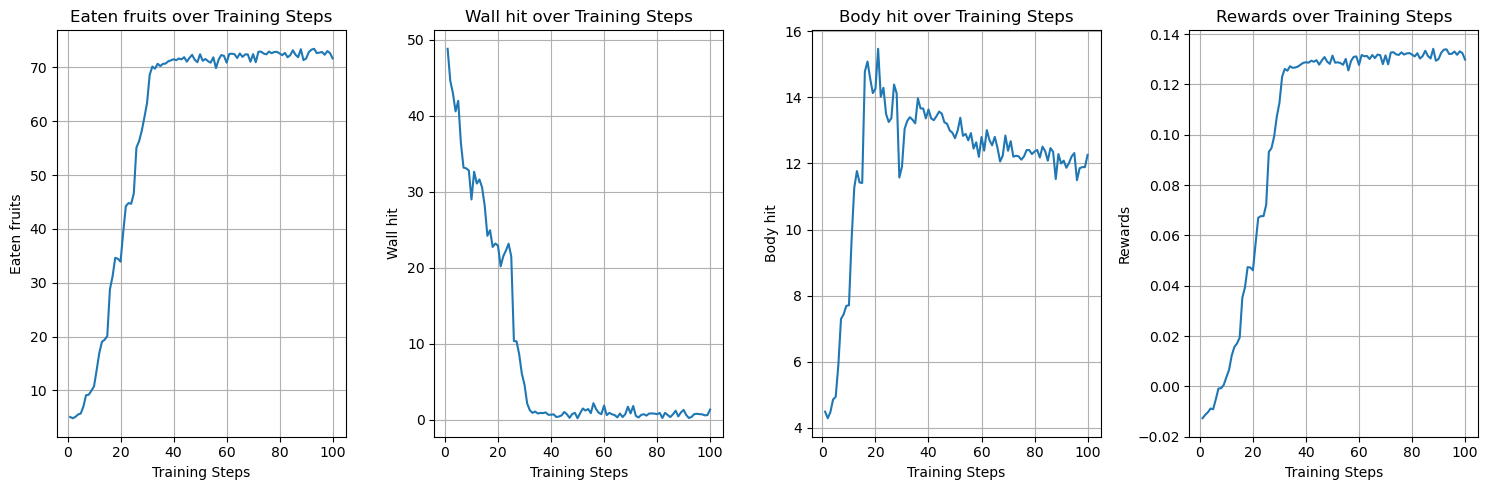

In [19]:
plotting(max_steps, n_fruit_eaten_tr, n_wall_hit_tr, n_body_hit_tr, rewards_tr)

rewards_ep = np.mean(np.reshape(rewards_tr, (100, 200)), axis=1)
n_fruit_eaten_ep = np.mean(np.reshape(n_fruit_eaten_tr, (100, 200)), axis=1)
n_wall_hit_ep = np.mean(np.reshape(n_wall_hit_tr, (100, 200)), axis=1)
n_body_hit_ep = np.mean(np.reshape(n_body_hit_tr, (100, 200)), axis=1)
max_steps = rewards_ep.shape[0]

plotting(max_steps, n_fruit_eaten_ep, n_wall_hit_ep, n_body_hit_ep, rewards_ep)

### Save data

In [20]:
# Save the data
np.savez("data_ddqn_rewards.npz", max_steps=max_steps, n_fruit_eaten_ep=n_fruit_eaten_ep, n_wall_hit_ep=n_wall_hit_ep, n_body_hit_ep=n_body_hit_ep, rewards_ep=rewards_ep)

# Test

In [21]:
batch_size = 256

# Initialize the environment
envs = get_env(batch_size)
action_dim = 4  # Dimensionality of the action space

# Create an instance of the QN model
q_net_test = DDQN(action_dim)

q_net_test.model(envs.to_state())

q_net_test.model.load_weights('weights_ddqn_rew.weights.h5')

max_steps = int(5000)

rewards_ts, n_fruit_eaten_ts, n_wall_hit_ts, n_body_hit_ts, fruit_data_ts, head_data_ts, body_data_ts = test(envs, q_net_test, max_steps)

100%|██████████| 5000/5000 [01:12<00:00, 68.74it/s]

Testing complete!


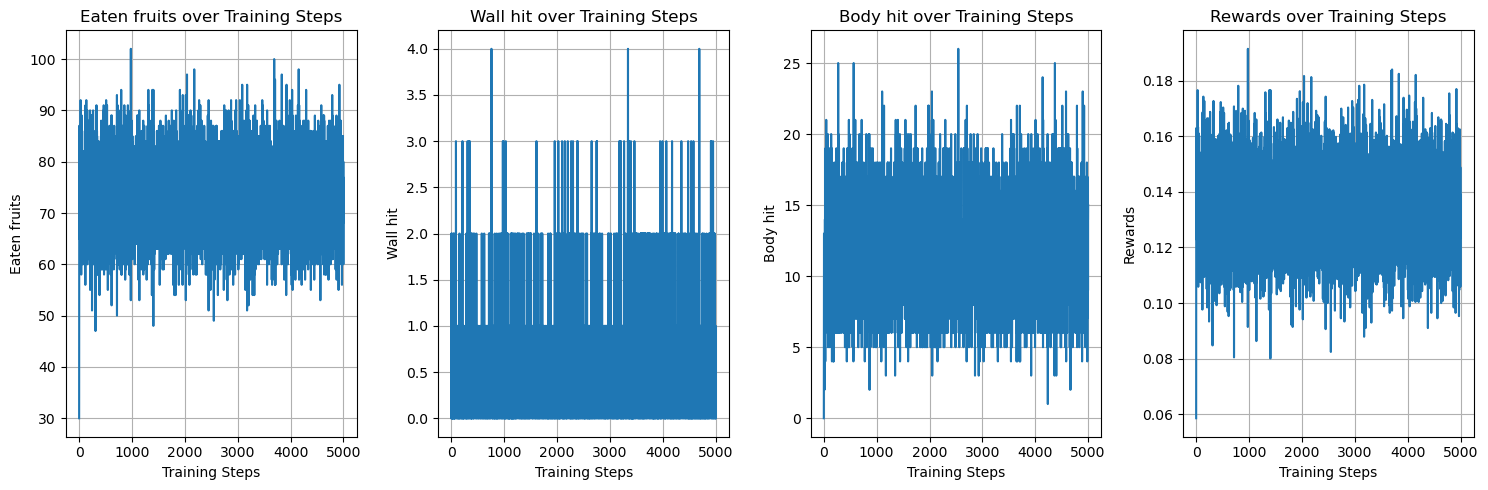

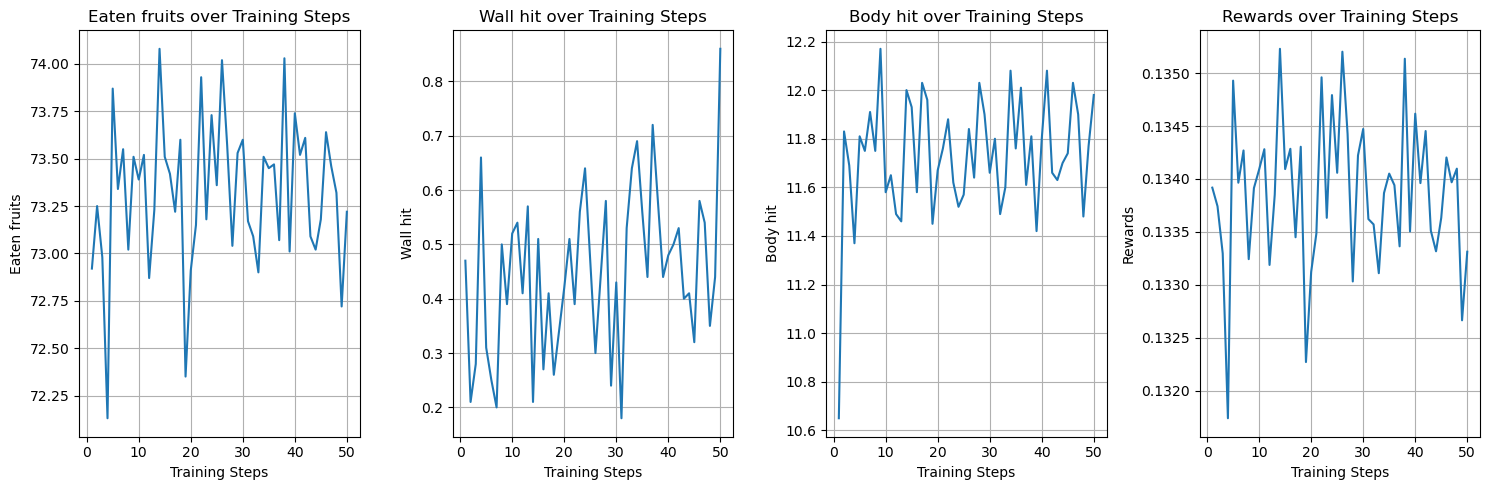

In [22]:
plotting(max_steps, n_fruit_eaten_ts, n_wall_hit_ts, n_body_hit_ts, rewards_ts)

rewards_ep = np.mean(np.reshape(rewards_ts, (50, 100)), axis=1)
n_fruit_eaten_ep = np.mean(np.reshape(n_fruit_eaten_ts, (50, 100)), axis=1)
n_wall_hit_ep = np.mean(np.reshape(n_wall_hit_ts, (50, 100)), axis=1)
n_body_hit_ep = np.mean(np.reshape(n_body_hit_ts, (50, 100)), axis=1)
max_steps = rewards_ep.shape[0]

plotting(max_steps, n_fruit_eaten_ep, n_wall_hit_ep, n_body_hit_ep, rewards_ep)

In [23]:
print("The average reward is:", np.mean(rewards_ts))

The average reward is: 0.13386734


# Video rendering

In [ ]:
from baseline import *

game_animation(envs, head_data_ts, body_data_ts, fruit_data_ts, 500, size)

print("Finished")